In [2]:
import os
import torch
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from sklearn.model_selection import train_test_split

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
# Load dataset
df = pd.read_parquet("../data/processed_emoji_dataset.parquet")
df["combined_embedding"] = df["combined_embedding"].apply(lambda x: np.array(x, dtype=np.float32))

In [4]:
# Split dataset into training (80%) and validation (20%)
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

In [5]:
class EmojiDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        text_embedding = torch.tensor(self.dataframe.iloc[idx]["combined_embedding"]).float()
        image_tensor = torch.load(self.dataframe.iloc[idx]["image_path"]).float()
        return text_embedding, image_tensor

In [6]:
# Create DataLoaders
train_dataset = EmojiDataset(train_df)
val_dataset = EmojiDataset(val_df)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

print("Datasets loaded successfully!")

Datasets loaded successfully!


In [7]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        def conv_block(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.ReLU(),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.ReLU()
            )

        self.encoder1 = conv_block(3, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.encoder2 = conv_block(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.bottleneck = conv_block(128, 256)
        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.decoder2 = conv_block(128 + 128, 128)
        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.decoder1 = conv_block(64 + 64, 64)
        self.final_conv = nn.Conv2d(64, 3, kernel_size=1)

    def forward(self, x):
        enc1 = self.encoder1(x)
        x = self.pool1(enc1)
        enc2 = self.encoder2(x)
        x = self.pool2(enc2)
        x = self.bottleneck(x)
        x = self.up2(x)
        x = torch.cat([x, enc2], dim=1)
        x = self.decoder2(x)
        x = self.up1(x)
        x = torch.cat([x, enc1], dim=1)
        x = self.decoder1(x)
        return self.final_conv(x)

In [8]:
class DiffusionModel:
    def __init__(self, timesteps=1000):
        self.timesteps = timesteps
        self.beta = torch.linspace(1e-4, 0.02, timesteps).to(device)
        self.alpha = 1.0 - self.beta
        self.alpha_bar = torch.cumprod(self.alpha, dim=0)

    def add_noise(self, images, t):
        noise = torch.randn_like(images)
        alpha_bar_t = self.alpha_bar[t].view(-1, 1, 1, 1)
        noisy_images = torch.sqrt(alpha_bar_t) * images + torch.sqrt(1 - alpha_bar_t) * noise
        return noisy_images, noise
    
    def sample(self, model, shape):
        x = torch.randn(shape).to(device)
        for t in reversed(range(self.timesteps)):
            with torch.no_grad():
                noise_pred = model(x)
                beta_t = self.beta[t].view(1, 1, 1, 1)
                alpha_t = self.alpha[t].view(1, 1, 1, 1)
                alpha_bar_t = self.alpha_bar[t].view(1, 1, 1, 1)

                if t > 0:
                    z = torch.randn_like(x)  
                else:
                    z = 0  # No noise at final step

                x = (1 / torch.sqrt(alpha_t)) * (x - ((1 - alpha_t) / torch.sqrt(1 - alpha_bar_t)) * noise_pred) + torch.sqrt(beta_t) * z
        return x

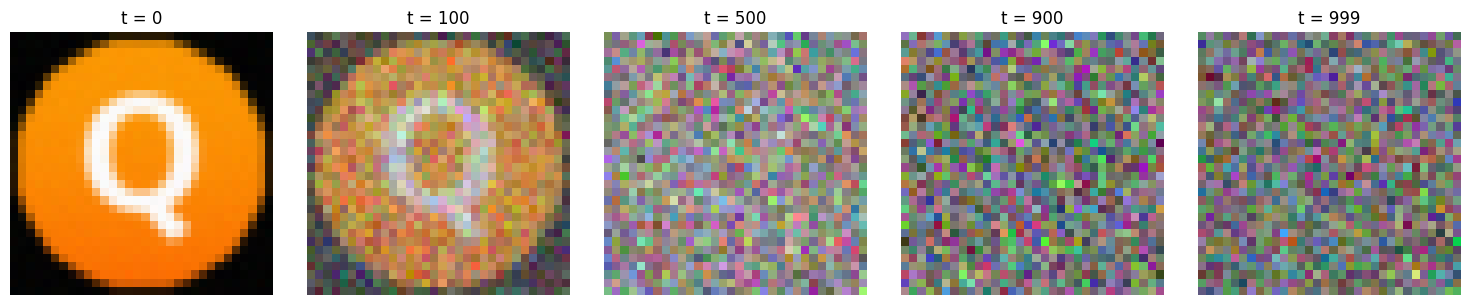

In [9]:
# Select a real image from the dataset
_, real_image = train_dataset[11]  # Get an image (ignore text embedding)
real_image = real_image.unsqueeze(0).to(device)  # Add batch dim & move to GPU

# Define timesteps to visualize
timesteps = [0, 100, 500, 900, 999]  # 0 (original), 999 (maximum noise)
noisy_images = []

# Apply noise using the DiffusionModel class
diffusion = DiffusionModel(timesteps=1000)  # Ensure it matches your training setup

for t in timesteps:
    t_tensor = torch.tensor([t], dtype=torch.long, device=device)  # Convert t to tensor
    xt, _ = diffusion.add_noise(real_image, t_tensor)

    # Convert to CPU & normalize for visualization
    img_np = xt.cpu().squeeze(0).permute(1, 2, 0).numpy()

    # Normalize image to [0,1] to prevent display issues
    img_min, img_max = img_np.min(), img_np.max()
    if img_max > img_min:  # Avoid division by zero
        img_np = (img_np - img_min) / (img_max - img_min)
    
    noisy_images.append(img_np)

# Plot the images
fig, axes = plt.subplots(1, len(timesteps), figsize=(15, 3))

for i, ax in enumerate(axes):
    ax.imshow(noisy_images[i])
    ax.set_title(f"t = {timesteps[i]}")
    ax.axis("off")

plt.tight_layout()
plt.show()

In [10]:
# Initialize Model, Diffusion, and Optimizer
model = UNet().to(device)
diffusion = DiffusionModel()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=5, verbose=True)
loss_fn = nn.L1Loss()

c:\Study\College\Project\myvenv\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [11]:
epochs = 200
train_losses = []
val_losses = []
best_val_loss = float("inf")

for epoch in range(epochs):
    total_train_loss = 0
    total_val_loss = 0
    
    model.train()
    loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{epochs}]")
    
    for embeddings, images in loop:
        images = images.to(device)
        t = torch.randint(0, 1000, (images.shape[0],), dtype=torch.long).to(device)
        noisy_images, noise = diffusion.add_noise(images, t)
        
        optimizer.zero_grad()
        predicted_noise = model(noisy_images)
        loss = loss_fn(predicted_noise, noise)
        loss.backward()
        optimizer.step()
        
        total_train_loss += loss.item()
        loop.set_postfix(train_loss=loss.item())
    
    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    model.eval()
    with torch.no_grad():
        for embeddings, images in val_loader:
            images = images.to(device)
            t = torch.randint(0, 1000, (images.shape[0],), dtype=torch.long).to(device)
            noisy_images, noise = diffusion.add_noise(images, t)
            predicted_noise = model(noisy_images)
            val_loss = loss_fn(predicted_noise, noise)
            total_val_loss += val_loss.item()

    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    scheduler.step(avg_val_loss)

    print(f"Epoch [{epoch+1}/{epochs}] - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), "best_model.pth")
        print(f" Best model saved at epoch {epoch+1}")

torch.save(model.state_dict(), "last_model.pth")
print(" Final model saved")



Epoch [1/200]: 100%|██████████| 157/157 [00:07<00:00, 19.89it/s, train_loss=0.222]


Epoch [1/200] - Train Loss: 0.5105, Val Loss: 0.2876
 Best model saved at epoch 1


Epoch [2/200]: 100%|██████████| 157/157 [00:07<00:00, 21.29it/s, train_loss=0.283]


Epoch [2/200] - Train Loss: 0.2707, Val Loss: 0.2682
 Best model saved at epoch 2


Epoch [3/200]: 100%|██████████| 157/157 [00:07<00:00, 21.49it/s, train_loss=0.292]


Epoch [3/200] - Train Loss: 0.2546, Val Loss: 0.2497
 Best model saved at epoch 3


Epoch [4/200]: 100%|██████████| 157/157 [00:07<00:00, 21.47it/s, train_loss=0.23] 


Epoch [4/200] - Train Loss: 0.2382, Val Loss: 0.2356
 Best model saved at epoch 4


Epoch [5/200]: 100%|██████████| 157/157 [00:07<00:00, 21.32it/s, train_loss=0.255]


Epoch [5/200] - Train Loss: 0.2250, Val Loss: 0.2180
 Best model saved at epoch 5


Epoch [6/200]: 100%|██████████| 157/157 [00:07<00:00, 21.11it/s, train_loss=0.201]


Epoch [6/200] - Train Loss: 0.2152, Val Loss: 0.2019
 Best model saved at epoch 6


Epoch [7/200]: 100%|██████████| 157/157 [00:07<00:00, 21.06it/s, train_loss=0.177]


Epoch [7/200] - Train Loss: 0.2003, Val Loss: 0.1972
 Best model saved at epoch 7


Epoch [8/200]: 100%|██████████| 157/157 [00:07<00:00, 21.08it/s, train_loss=0.154]


Epoch [8/200] - Train Loss: 0.1929, Val Loss: 0.1828
 Best model saved at epoch 8


Epoch [9/200]: 100%|██████████| 157/157 [00:07<00:00, 21.25it/s, train_loss=0.162]


Epoch [9/200] - Train Loss: 0.1839, Val Loss: 0.1844


Epoch [10/200]: 100%|██████████| 157/157 [00:07<00:00, 21.27it/s, train_loss=0.133]


Epoch [10/200] - Train Loss: 0.1812, Val Loss: 0.1796
 Best model saved at epoch 10


Epoch [11/200]: 100%|██████████| 157/157 [00:07<00:00, 21.25it/s, train_loss=0.167]


Epoch [11/200] - Train Loss: 0.1750, Val Loss: 0.1728
 Best model saved at epoch 11


Epoch [12/200]: 100%|██████████| 157/157 [00:07<00:00, 21.11it/s, train_loss=0.243]


Epoch [12/200] - Train Loss: 0.1719, Val Loss: 0.1696
 Best model saved at epoch 12


Epoch [13/200]: 100%|██████████| 157/157 [00:07<00:00, 21.24it/s, train_loss=0.179]


Epoch [13/200] - Train Loss: 0.1682, Val Loss: 0.1626
 Best model saved at epoch 13


Epoch [14/200]: 100%|██████████| 157/157 [00:07<00:00, 21.17it/s, train_loss=0.181]


Epoch [14/200] - Train Loss: 0.1647, Val Loss: 0.1636


Epoch [15/200]: 100%|██████████| 157/157 [00:07<00:00, 21.23it/s, train_loss=0.173]


Epoch [15/200] - Train Loss: 0.1618, Val Loss: 0.1588
 Best model saved at epoch 15


Epoch [16/200]: 100%|██████████| 157/157 [00:07<00:00, 21.14it/s, train_loss=0.154]


Epoch [16/200] - Train Loss: 0.1628, Val Loss: 0.1632


Epoch [17/200]: 100%|██████████| 157/157 [00:07<00:00, 21.21it/s, train_loss=0.121]


Epoch [17/200] - Train Loss: 0.1590, Val Loss: 0.1561
 Best model saved at epoch 17


Epoch [18/200]: 100%|██████████| 157/157 [00:07<00:00, 21.24it/s, train_loss=0.149]


Epoch [18/200] - Train Loss: 0.1596, Val Loss: 0.1598


Epoch [19/200]: 100%|██████████| 157/157 [00:07<00:00, 21.39it/s, train_loss=0.193]


Epoch [19/200] - Train Loss: 0.1538, Val Loss: 0.1534
 Best model saved at epoch 19


Epoch [20/200]: 100%|██████████| 157/157 [00:07<00:00, 21.48it/s, train_loss=0.15] 


Epoch [20/200] - Train Loss: 0.1530, Val Loss: 0.1540


Epoch [21/200]: 100%|██████████| 157/157 [00:07<00:00, 21.52it/s, train_loss=0.137]


Epoch [21/200] - Train Loss: 0.1538, Val Loss: 0.1541


Epoch [22/200]: 100%|██████████| 157/157 [00:07<00:00, 21.54it/s, train_loss=0.158]


Epoch [22/200] - Train Loss: 0.1528, Val Loss: 0.1521
 Best model saved at epoch 22


Epoch [23/200]: 100%|██████████| 157/157 [00:07<00:00, 21.55it/s, train_loss=0.134]


Epoch [23/200] - Train Loss: 0.1483, Val Loss: 0.1517
 Best model saved at epoch 23


Epoch [24/200]: 100%|██████████| 157/157 [00:07<00:00, 21.52it/s, train_loss=0.139]


Epoch [24/200] - Train Loss: 0.1474, Val Loss: 0.1543


Epoch [25/200]: 100%|██████████| 157/157 [00:07<00:00, 21.55it/s, train_loss=0.147]


Epoch [25/200] - Train Loss: 0.1492, Val Loss: 0.1556


Epoch [26/200]: 100%|██████████| 157/157 [00:07<00:00, 21.44it/s, train_loss=0.147]


Epoch [26/200] - Train Loss: 0.1498, Val Loss: 0.1476
 Best model saved at epoch 26


Epoch [27/200]: 100%|██████████| 157/157 [00:07<00:00, 21.41it/s, train_loss=0.147]


Epoch [27/200] - Train Loss: 0.1453, Val Loss: 0.1500


Epoch [28/200]: 100%|██████████| 157/157 [00:07<00:00, 21.50it/s, train_loss=0.146]


Epoch [28/200] - Train Loss: 0.1461, Val Loss: 0.1441
 Best model saved at epoch 28


Epoch [29/200]: 100%|██████████| 157/157 [00:07<00:00, 21.40it/s, train_loss=0.145]


Epoch [29/200] - Train Loss: 0.1439, Val Loss: 0.1395
 Best model saved at epoch 29


Epoch [30/200]: 100%|██████████| 157/157 [00:07<00:00, 21.42it/s, train_loss=0.133]


Epoch [30/200] - Train Loss: 0.1414, Val Loss: 0.1478


Epoch [31/200]: 100%|██████████| 157/157 [00:07<00:00, 21.46it/s, train_loss=0.141]


Epoch [31/200] - Train Loss: 0.1433, Val Loss: 0.1457


Epoch [32/200]: 100%|██████████| 157/157 [00:07<00:00, 21.33it/s, train_loss=0.114]


Epoch [32/200] - Train Loss: 0.1445, Val Loss: 0.1397


Epoch [33/200]: 100%|██████████| 157/157 [00:07<00:00, 21.30it/s, train_loss=0.126]


Epoch [33/200] - Train Loss: 0.1403, Val Loss: 0.1401


Epoch [34/200]: 100%|██████████| 157/157 [00:07<00:00, 21.17it/s, train_loss=0.109]


Epoch [34/200] - Train Loss: 0.1405, Val Loss: 0.1415


Epoch [35/200]: 100%|██████████| 157/157 [00:07<00:00, 21.23it/s, train_loss=0.132]


Epoch [35/200] - Train Loss: 0.1379, Val Loss: 0.1389
 Best model saved at epoch 35


Epoch [36/200]: 100%|██████████| 157/157 [00:07<00:00, 21.18it/s, train_loss=0.176]


Epoch [36/200] - Train Loss: 0.1387, Val Loss: 0.1350
 Best model saved at epoch 36


Epoch [37/200]: 100%|██████████| 157/157 [00:07<00:00, 21.37it/s, train_loss=0.107]


Epoch [37/200] - Train Loss: 0.1363, Val Loss: 0.1383


Epoch [38/200]: 100%|██████████| 157/157 [00:07<00:00, 21.32it/s, train_loss=0.209]


Epoch [38/200] - Train Loss: 0.1377, Val Loss: 0.1352


Epoch [39/200]: 100%|██████████| 157/157 [00:07<00:00, 20.82it/s, train_loss=0.144]


Epoch [39/200] - Train Loss: 0.1395, Val Loss: 0.1323
 Best model saved at epoch 39


Epoch [40/200]: 100%|██████████| 157/157 [00:07<00:00, 21.32it/s, train_loss=0.13] 


Epoch [40/200] - Train Loss: 0.1315, Val Loss: 0.1410


Epoch [41/200]: 100%|██████████| 157/157 [00:07<00:00, 21.31it/s, train_loss=0.111]


Epoch [41/200] - Train Loss: 0.1361, Val Loss: 0.1390


Epoch [42/200]: 100%|██████████| 157/157 [00:07<00:00, 21.38it/s, train_loss=0.15] 


Epoch [42/200] - Train Loss: 0.1344, Val Loss: 0.1322
 Best model saved at epoch 42


Epoch [43/200]: 100%|██████████| 157/157 [00:07<00:00, 21.29it/s, train_loss=0.139] 


Epoch [43/200] - Train Loss: 0.1339, Val Loss: 0.1278
 Best model saved at epoch 43


Epoch [44/200]: 100%|██████████| 157/157 [00:07<00:00, 21.29it/s, train_loss=0.152] 


Epoch [44/200] - Train Loss: 0.1329, Val Loss: 0.1316


Epoch [45/200]: 100%|██████████| 157/157 [00:07<00:00, 21.39it/s, train_loss=0.151]


Epoch [45/200] - Train Loss: 0.1310, Val Loss: 0.1349


Epoch [46/200]: 100%|██████████| 157/157 [00:07<00:00, 21.36it/s, train_loss=0.122]


Epoch [46/200] - Train Loss: 0.1282, Val Loss: 0.1272
 Best model saved at epoch 46


Epoch [47/200]: 100%|██████████| 157/157 [00:07<00:00, 21.39it/s, train_loss=0.127] 


Epoch [47/200] - Train Loss: 0.1328, Val Loss: 0.1324


Epoch [48/200]: 100%|██████████| 157/157 [00:07<00:00, 21.16it/s, train_loss=0.187] 


Epoch [48/200] - Train Loss: 0.1308, Val Loss: 0.1297


Epoch [49/200]: 100%|██████████| 157/157 [00:07<00:00, 21.27it/s, train_loss=0.0914]


Epoch [49/200] - Train Loss: 0.1295, Val Loss: 0.1336


Epoch [50/200]: 100%|██████████| 157/157 [00:07<00:00, 21.33it/s, train_loss=0.125] 


Epoch [50/200] - Train Loss: 0.1303, Val Loss: 0.1246
 Best model saved at epoch 50


Epoch [51/200]: 100%|██████████| 157/157 [00:07<00:00, 21.21it/s, train_loss=0.121] 


Epoch [51/200] - Train Loss: 0.1285, Val Loss: 0.1387


Epoch [52/200]: 100%|██████████| 157/157 [00:07<00:00, 21.17it/s, train_loss=0.101] 


Epoch [52/200] - Train Loss: 0.1285, Val Loss: 0.1338


Epoch [53/200]: 100%|██████████| 157/157 [00:07<00:00, 21.20it/s, train_loss=0.149] 


Epoch [53/200] - Train Loss: 0.1290, Val Loss: 0.1308


Epoch [54/200]: 100%|██████████| 157/157 [00:07<00:00, 21.36it/s, train_loss=0.154]


Epoch [54/200] - Train Loss: 0.1257, Val Loss: 0.1259


Epoch [55/200]: 100%|██████████| 157/157 [00:07<00:00, 21.28it/s, train_loss=0.171]


Epoch [55/200] - Train Loss: 0.1256, Val Loss: 0.1217
 Best model saved at epoch 55


Epoch [56/200]: 100%|██████████| 157/157 [00:07<00:00, 21.26it/s, train_loss=0.128]


Epoch [56/200] - Train Loss: 0.1255, Val Loss: 0.1279


Epoch [57/200]: 100%|██████████| 157/157 [00:07<00:00, 21.43it/s, train_loss=0.121] 


Epoch [57/200] - Train Loss: 0.1268, Val Loss: 0.1231


Epoch [58/200]: 100%|██████████| 157/157 [00:07<00:00, 21.26it/s, train_loss=0.145]


Epoch [58/200] - Train Loss: 0.1274, Val Loss: 0.1283


Epoch [59/200]: 100%|██████████| 157/157 [00:07<00:00, 21.41it/s, train_loss=0.135] 


Epoch [59/200] - Train Loss: 0.1252, Val Loss: 0.1246


Epoch [60/200]: 100%|██████████| 157/157 [00:07<00:00, 21.41it/s, train_loss=0.0962]


Epoch [60/200] - Train Loss: 0.1233, Val Loss: 0.1266


Epoch [61/200]: 100%|██████████| 157/157 [00:07<00:00, 21.31it/s, train_loss=0.114] 


Epoch [61/200] - Train Loss: 0.1245, Val Loss: 0.1255


Epoch [62/200]: 100%|██████████| 157/157 [00:07<00:00, 21.20it/s, train_loss=0.114]


Epoch [62/200] - Train Loss: 0.1225, Val Loss: 0.1228


Epoch [63/200]: 100%|██████████| 157/157 [00:07<00:00, 21.32it/s, train_loss=0.129] 


Epoch [63/200] - Train Loss: 0.1206, Val Loss: 0.1228


Epoch [64/200]: 100%|██████████| 157/157 [00:07<00:00, 21.06it/s, train_loss=0.12]  


Epoch [64/200] - Train Loss: 0.1223, Val Loss: 0.1214
 Best model saved at epoch 64


Epoch [65/200]: 100%|██████████| 157/157 [00:07<00:00, 21.38it/s, train_loss=0.159] 


Epoch [65/200] - Train Loss: 0.1216, Val Loss: 0.1221


Epoch [66/200]: 100%|██████████| 157/157 [00:07<00:00, 21.46it/s, train_loss=0.147] 


Epoch [66/200] - Train Loss: 0.1227, Val Loss: 0.1213
 Best model saved at epoch 66


Epoch [67/200]: 100%|██████████| 157/157 [00:07<00:00, 21.33it/s, train_loss=0.119] 


Epoch [67/200] - Train Loss: 0.1224, Val Loss: 0.1263


Epoch [68/200]: 100%|██████████| 157/157 [00:07<00:00, 21.23it/s, train_loss=0.103] 


Epoch [68/200] - Train Loss: 0.1239, Val Loss: 0.1224


Epoch [69/200]: 100%|██████████| 157/157 [00:07<00:00, 21.25it/s, train_loss=0.117] 


Epoch [69/200] - Train Loss: 0.1195, Val Loss: 0.1188
 Best model saved at epoch 69


Epoch [70/200]: 100%|██████████| 157/157 [00:07<00:00, 21.32it/s, train_loss=0.121] 


Epoch [70/200] - Train Loss: 0.1213, Val Loss: 0.1264


Epoch [71/200]: 100%|██████████| 157/157 [00:07<00:00, 21.42it/s, train_loss=0.106] 


Epoch [71/200] - Train Loss: 0.1193, Val Loss: 0.1176
 Best model saved at epoch 71


Epoch [72/200]: 100%|██████████| 157/157 [00:07<00:00, 21.30it/s, train_loss=0.161] 


Epoch [72/200] - Train Loss: 0.1206, Val Loss: 0.1172
 Best model saved at epoch 72


Epoch [73/200]: 100%|██████████| 157/157 [00:07<00:00, 21.40it/s, train_loss=0.102] 


Epoch [73/200] - Train Loss: 0.1189, Val Loss: 0.1201


Epoch [74/200]: 100%|██████████| 157/157 [00:07<00:00, 21.37it/s, train_loss=0.115] 


Epoch [74/200] - Train Loss: 0.1191, Val Loss: 0.1179


Epoch [75/200]: 100%|██████████| 157/157 [00:07<00:00, 21.31it/s, train_loss=0.101] 


Epoch [75/200] - Train Loss: 0.1195, Val Loss: 0.1222


Epoch [76/200]: 100%|██████████| 157/157 [00:07<00:00, 20.95it/s, train_loss=0.108] 


Epoch [76/200] - Train Loss: 0.1176, Val Loss: 0.1234


Epoch [77/200]: 100%|██████████| 157/157 [00:07<00:00, 21.43it/s, train_loss=0.1]   


Epoch [77/200] - Train Loss: 0.1172, Val Loss: 0.1175


Epoch [78/200]: 100%|██████████| 157/157 [00:07<00:00, 21.27it/s, train_loss=0.113] 


Epoch [78/200] - Train Loss: 0.1183, Val Loss: 0.1175


Epoch [79/200]: 100%|██████████| 157/157 [00:07<00:00, 21.46it/s, train_loss=0.107] 


Epoch [79/200] - Train Loss: 0.1180, Val Loss: 0.1186


Epoch [80/200]: 100%|██████████| 157/157 [00:07<00:00, 21.48it/s, train_loss=0.101] 


Epoch [80/200] - Train Loss: 0.1167, Val Loss: 0.1200


Epoch [81/200]: 100%|██████████| 157/157 [00:07<00:00, 21.41it/s, train_loss=0.11]  


Epoch [81/200] - Train Loss: 0.1170, Val Loss: 0.1142
 Best model saved at epoch 81


Epoch [82/200]: 100%|██████████| 157/157 [00:07<00:00, 21.38it/s, train_loss=0.118] 


Epoch [82/200] - Train Loss: 0.1158, Val Loss: 0.1189


Epoch [83/200]: 100%|██████████| 157/157 [00:07<00:00, 21.37it/s, train_loss=0.0803]


Epoch [83/200] - Train Loss: 0.1164, Val Loss: 0.1203


Epoch [84/200]: 100%|██████████| 157/157 [00:07<00:00, 21.48it/s, train_loss=0.0908]


Epoch [84/200] - Train Loss: 0.1166, Val Loss: 0.1183


Epoch [85/200]: 100%|██████████| 157/157 [00:07<00:00, 21.25it/s, train_loss=0.148] 


Epoch [85/200] - Train Loss: 0.1177, Val Loss: 0.1164


Epoch [86/200]: 100%|██████████| 157/157 [00:07<00:00, 21.39it/s, train_loss=0.101] 


Epoch [86/200] - Train Loss: 0.1175, Val Loss: 0.1139
 Best model saved at epoch 86


Epoch [87/200]: 100%|██████████| 157/157 [00:07<00:00, 21.18it/s, train_loss=0.118] 


Epoch [87/200] - Train Loss: 0.1160, Val Loss: 0.1166


Epoch [88/200]: 100%|██████████| 157/157 [00:07<00:00, 21.49it/s, train_loss=0.12]  


Epoch [88/200] - Train Loss: 0.1167, Val Loss: 0.1143


Epoch [89/200]: 100%|██████████| 157/157 [00:07<00:00, 21.32it/s, train_loss=0.0937]


Epoch [89/200] - Train Loss: 0.1175, Val Loss: 0.1121
 Best model saved at epoch 89


Epoch [90/200]: 100%|██████████| 157/157 [00:07<00:00, 21.23it/s, train_loss=0.122] 


Epoch [90/200] - Train Loss: 0.1163, Val Loss: 0.1146


Epoch [91/200]: 100%|██████████| 157/157 [00:07<00:00, 21.17it/s, train_loss=0.118] 


Epoch [91/200] - Train Loss: 0.1169, Val Loss: 0.1145


Epoch [92/200]: 100%|██████████| 157/157 [00:07<00:00, 21.10it/s, train_loss=0.089] 


Epoch [92/200] - Train Loss: 0.1147, Val Loss: 0.1151


Epoch [93/200]: 100%|██████████| 157/157 [00:07<00:00, 21.20it/s, train_loss=0.136] 


Epoch [93/200] - Train Loss: 0.1157, Val Loss: 0.1152


Epoch [94/200]: 100%|██████████| 157/157 [00:07<00:00, 21.41it/s, train_loss=0.144] 


Epoch [94/200] - Train Loss: 0.1149, Val Loss: 0.1192


Epoch [95/200]: 100%|██████████| 157/157 [00:07<00:00, 21.34it/s, train_loss=0.14]  


Epoch [95/200] - Train Loss: 0.1133, Val Loss: 0.1176


Epoch [96/200]: 100%|██████████| 157/157 [00:07<00:00, 21.14it/s, train_loss=0.102] 


Epoch [96/200] - Train Loss: 0.1147, Val Loss: 0.1096
 Best model saved at epoch 96


Epoch [97/200]: 100%|██████████| 157/157 [00:07<00:00, 21.07it/s, train_loss=0.137] 


Epoch [97/200] - Train Loss: 0.1161, Val Loss: 0.1137


Epoch [98/200]: 100%|██████████| 157/157 [00:07<00:00, 21.16it/s, train_loss=0.146] 


Epoch [98/200] - Train Loss: 0.1126, Val Loss: 0.1102


Epoch [99/200]: 100%|██████████| 157/157 [00:07<00:00, 21.17it/s, train_loss=0.13]  


Epoch [99/200] - Train Loss: 0.1148, Val Loss: 0.1191


Epoch [100/200]: 100%|██████████| 157/157 [00:07<00:00, 21.35it/s, train_loss=0.156] 


Epoch [100/200] - Train Loss: 0.1131, Val Loss: 0.1106


Epoch [101/200]: 100%|██████████| 157/157 [00:07<00:00, 21.26it/s, train_loss=0.109] 


Epoch [101/200] - Train Loss: 0.1139, Val Loss: 0.1165


Epoch [102/200]: 100%|██████████| 157/157 [00:07<00:00, 21.10it/s, train_loss=0.107] 


Epoch [102/200] - Train Loss: 0.1130, Val Loss: 0.1148


Epoch [103/200]: 100%|██████████| 157/157 [00:07<00:00, 21.36it/s, train_loss=0.165] 


Epoch [103/200] - Train Loss: 0.1147, Val Loss: 0.1155


Epoch [104/200]: 100%|██████████| 157/157 [00:07<00:00, 21.49it/s, train_loss=0.124] 


Epoch [104/200] - Train Loss: 0.1139, Val Loss: 0.1128


Epoch [105/200]: 100%|██████████| 157/157 [00:07<00:00, 21.37it/s, train_loss=0.106] 


Epoch [105/200] - Train Loss: 0.1118, Val Loss: 0.1142


Epoch [106/200]: 100%|██████████| 157/157 [00:07<00:00, 21.55it/s, train_loss=0.143] 


Epoch [106/200] - Train Loss: 0.1136, Val Loss: 0.1111


Epoch [107/200]: 100%|██████████| 157/157 [00:07<00:00, 21.62it/s, train_loss=0.112] 


Epoch [107/200] - Train Loss: 0.1150, Val Loss: 0.1110


Epoch [108/200]: 100%|██████████| 157/157 [00:07<00:00, 21.45it/s, train_loss=0.145] 


Epoch [108/200] - Train Loss: 0.1143, Val Loss: 0.1097


Epoch [109/200]: 100%|██████████| 157/157 [00:07<00:00, 21.72it/s, train_loss=0.111] 


Epoch [109/200] - Train Loss: 0.1135, Val Loss: 0.1144


Epoch [110/200]: 100%|██████████| 157/157 [00:07<00:00, 21.48it/s, train_loss=0.12]  


Epoch [110/200] - Train Loss: 0.1134, Val Loss: 0.1150


Epoch [111/200]: 100%|██████████| 157/157 [00:07<00:00, 21.49it/s, train_loss=0.0808]


Epoch [111/200] - Train Loss: 0.1131, Val Loss: 0.1105


Epoch [112/200]: 100%|██████████| 157/157 [00:07<00:00, 21.40it/s, train_loss=0.112] 


Epoch [112/200] - Train Loss: 0.1146, Val Loss: 0.1118


Epoch [113/200]: 100%|██████████| 157/157 [00:07<00:00, 21.43it/s, train_loss=0.0903]


Epoch [113/200] - Train Loss: 0.1112, Val Loss: 0.1178


Epoch [114/200]: 100%|██████████| 157/157 [00:07<00:00, 21.07it/s, train_loss=0.0932]


Epoch [114/200] - Train Loss: 0.1141, Val Loss: 0.1093
 Best model saved at epoch 114


Epoch [115/200]: 100%|██████████| 157/157 [00:07<00:00, 21.22it/s, train_loss=0.167] 


Epoch [115/200] - Train Loss: 0.1129, Val Loss: 0.1144


Epoch [116/200]: 100%|██████████| 157/157 [00:07<00:00, 21.15it/s, train_loss=0.098] 


Epoch [116/200] - Train Loss: 0.1129, Val Loss: 0.1093
 Best model saved at epoch 116


Epoch [117/200]: 100%|██████████| 157/157 [00:07<00:00, 20.95it/s, train_loss=0.11]  


Epoch [117/200] - Train Loss: 0.1128, Val Loss: 0.1114


Epoch [118/200]: 100%|██████████| 157/157 [00:07<00:00, 21.16it/s, train_loss=0.101] 


Epoch [118/200] - Train Loss: 0.1135, Val Loss: 0.1140


Epoch [119/200]: 100%|██████████| 157/157 [00:07<00:00, 21.18it/s, train_loss=0.0676]


Epoch [119/200] - Train Loss: 0.1122, Val Loss: 0.1132


Epoch [120/200]: 100%|██████████| 157/157 [00:07<00:00, 21.15it/s, train_loss=0.0926]


Epoch [120/200] - Train Loss: 0.1136, Val Loss: 0.1097


Epoch [121/200]: 100%|██████████| 157/157 [00:07<00:00, 21.36it/s, train_loss=0.121] 


Epoch [121/200] - Train Loss: 0.1124, Val Loss: 0.1112


Epoch [122/200]: 100%|██████████| 157/157 [00:07<00:00, 21.41it/s, train_loss=0.0886]


Epoch [122/200] - Train Loss: 0.1124, Val Loss: 0.1114


Epoch [123/200]: 100%|██████████| 157/157 [00:07<00:00, 21.30it/s, train_loss=0.0632]


Epoch [123/200] - Train Loss: 0.1136, Val Loss: 0.1129


Epoch [124/200]: 100%|██████████| 157/157 [00:07<00:00, 21.26it/s, train_loss=0.0988]


Epoch [124/200] - Train Loss: 0.1124, Val Loss: 0.1103


Epoch [125/200]: 100%|██████████| 157/157 [00:07<00:00, 21.20it/s, train_loss=0.1]   


Epoch [125/200] - Train Loss: 0.1148, Val Loss: 0.1192


Epoch [126/200]: 100%|██████████| 157/157 [00:07<00:00, 21.01it/s, train_loss=0.104] 


Epoch [126/200] - Train Loss: 0.1129, Val Loss: 0.1193


Epoch [127/200]: 100%|██████████| 157/157 [00:07<00:00, 21.01it/s, train_loss=0.128] 


Epoch [127/200] - Train Loss: 0.1132, Val Loss: 0.1168


Epoch [128/200]: 100%|██████████| 157/157 [00:07<00:00, 21.35it/s, train_loss=0.0831]


Epoch [128/200] - Train Loss: 0.1115, Val Loss: 0.1119


Epoch [129/200]: 100%|██████████| 157/157 [00:07<00:00, 21.20it/s, train_loss=0.148] 


Epoch [129/200] - Train Loss: 0.1135, Val Loss: 0.1170


Epoch [130/200]: 100%|██████████| 157/157 [00:07<00:00, 21.39it/s, train_loss=0.168] 


Epoch [130/200] - Train Loss: 0.1117, Val Loss: 0.1139


Epoch [131/200]: 100%|██████████| 157/157 [00:07<00:00, 21.29it/s, train_loss=0.139] 


Epoch [131/200] - Train Loss: 0.1124, Val Loss: 0.1096


Epoch [132/200]: 100%|██████████| 157/157 [00:07<00:00, 21.57it/s, train_loss=0.137] 


Epoch [132/200] - Train Loss: 0.1144, Val Loss: 0.1098


Epoch [133/200]: 100%|██████████| 157/157 [00:07<00:00, 21.48it/s, train_loss=0.121] 


Epoch [133/200] - Train Loss: 0.1125, Val Loss: 0.1137


Epoch [134/200]: 100%|██████████| 157/157 [00:07<00:00, 21.61it/s, train_loss=0.131] 


Epoch [134/200] - Train Loss: 0.1122, Val Loss: 0.1142


Epoch [135/200]: 100%|██████████| 157/157 [00:07<00:00, 21.66it/s, train_loss=0.117] 


Epoch [135/200] - Train Loss: 0.1134, Val Loss: 0.1075
 Best model saved at epoch 135


Epoch [136/200]: 100%|██████████| 157/157 [00:07<00:00, 21.60it/s, train_loss=0.113] 


Epoch [136/200] - Train Loss: 0.1144, Val Loss: 0.1149


Epoch [137/200]: 100%|██████████| 157/157 [00:07<00:00, 21.66it/s, train_loss=0.0687]


Epoch [137/200] - Train Loss: 0.1118, Val Loss: 0.1137


Epoch [138/200]: 100%|██████████| 157/157 [00:07<00:00, 21.54it/s, train_loss=0.131] 


Epoch [138/200] - Train Loss: 0.1150, Val Loss: 0.1152


Epoch [139/200]: 100%|██████████| 157/157 [00:07<00:00, 21.48it/s, train_loss=0.113] 


Epoch [139/200] - Train Loss: 0.1127, Val Loss: 0.1118


Epoch [140/200]: 100%|██████████| 157/157 [00:07<00:00, 21.40it/s, train_loss=0.134] 


Epoch [140/200] - Train Loss: 0.1141, Val Loss: 0.1143


Epoch [141/200]: 100%|██████████| 157/157 [00:07<00:00, 21.43it/s, train_loss=0.162] 


Epoch [141/200] - Train Loss: 0.1118, Val Loss: 0.1142


Epoch [142/200]: 100%|██████████| 157/157 [00:07<00:00, 21.49it/s, train_loss=0.135] 


Epoch [142/200] - Train Loss: 0.1119, Val Loss: 0.1157


Epoch [143/200]: 100%|██████████| 157/157 [00:07<00:00, 21.39it/s, train_loss=0.098] 


Epoch [143/200] - Train Loss: 0.1130, Val Loss: 0.1146


Epoch [144/200]: 100%|██████████| 157/157 [00:07<00:00, 21.49it/s, train_loss=0.139] 


Epoch [144/200] - Train Loss: 0.1149, Val Loss: 0.1138


Epoch [145/200]: 100%|██████████| 157/157 [00:07<00:00, 21.40it/s, train_loss=0.112] 


Epoch [145/200] - Train Loss: 0.1149, Val Loss: 0.1135


Epoch [146/200]: 100%|██████████| 157/157 [00:07<00:00, 20.96it/s, train_loss=0.141] 


Epoch [146/200] - Train Loss: 0.1120, Val Loss: 0.1166


Epoch [147/200]: 100%|██████████| 157/157 [00:07<00:00, 21.11it/s, train_loss=0.177] 


Epoch [147/200] - Train Loss: 0.1139, Val Loss: 0.1132


Epoch [148/200]: 100%|██████████| 157/157 [00:07<00:00, 21.19it/s, train_loss=0.101] 


Epoch [148/200] - Train Loss: 0.1119, Val Loss: 0.1116


Epoch [149/200]: 100%|██████████| 157/157 [00:07<00:00, 21.36it/s, train_loss=0.0992]


Epoch [149/200] - Train Loss: 0.1132, Val Loss: 0.1099


Epoch [150/200]: 100%|██████████| 157/157 [00:07<00:00, 21.27it/s, train_loss=0.107] 


Epoch [150/200] - Train Loss: 0.1128, Val Loss: 0.1155


Epoch [151/200]: 100%|██████████| 157/157 [00:07<00:00, 20.93it/s, train_loss=0.122] 


Epoch [151/200] - Train Loss: 0.1138, Val Loss: 0.1133


Epoch [152/200]: 100%|██████████| 157/157 [00:07<00:00, 21.30it/s, train_loss=0.104] 


Epoch [152/200] - Train Loss: 0.1125, Val Loss: 0.1109


Epoch [153/200]: 100%|██████████| 157/157 [00:07<00:00, 21.18it/s, train_loss=0.0939]


Epoch [153/200] - Train Loss: 0.1135, Val Loss: 0.1137


Epoch [154/200]: 100%|██████████| 157/157 [00:07<00:00, 21.10it/s, train_loss=0.0774]


Epoch [154/200] - Train Loss: 0.1130, Val Loss: 0.1113


Epoch [155/200]: 100%|██████████| 157/157 [00:07<00:00, 21.07it/s, train_loss=0.0873]


Epoch [155/200] - Train Loss: 0.1139, Val Loss: 0.1081


Epoch [156/200]: 100%|██████████| 157/157 [00:07<00:00, 21.33it/s, train_loss=0.0765]


Epoch [156/200] - Train Loss: 0.1133, Val Loss: 0.1105


Epoch [157/200]: 100%|██████████| 157/157 [00:07<00:00, 21.24it/s, train_loss=0.0846]


Epoch [157/200] - Train Loss: 0.1131, Val Loss: 0.1119


Epoch [158/200]: 100%|██████████| 157/157 [00:07<00:00, 21.26it/s, train_loss=0.108] 


Epoch [158/200] - Train Loss: 0.1143, Val Loss: 0.1144


Epoch [159/200]: 100%|██████████| 157/157 [00:07<00:00, 21.27it/s, train_loss=0.0946]


Epoch [159/200] - Train Loss: 0.1112, Val Loss: 0.1120


Epoch [160/200]: 100%|██████████| 157/157 [00:07<00:00, 21.41it/s, train_loss=0.117] 


Epoch [160/200] - Train Loss: 0.1113, Val Loss: 0.1099


Epoch [161/200]: 100%|██████████| 157/157 [00:07<00:00, 21.59it/s, train_loss=0.0889]


Epoch [161/200] - Train Loss: 0.1139, Val Loss: 0.1122


Epoch [162/200]: 100%|██████████| 157/157 [00:07<00:00, 21.56it/s, train_loss=0.112] 


Epoch [162/200] - Train Loss: 0.1116, Val Loss: 0.1075


Epoch [163/200]: 100%|██████████| 157/157 [00:07<00:00, 21.61it/s, train_loss=0.134] 


Epoch [163/200] - Train Loss: 0.1100, Val Loss: 0.1139


Epoch [164/200]: 100%|██████████| 157/157 [00:07<00:00, 21.57it/s, train_loss=0.0833]


Epoch [164/200] - Train Loss: 0.1138, Val Loss: 0.1179


Epoch [165/200]: 100%|██████████| 157/157 [00:07<00:00, 21.71it/s, train_loss=0.0855]


Epoch [165/200] - Train Loss: 0.1141, Val Loss: 0.1144


Epoch [166/200]: 100%|██████████| 157/157 [00:07<00:00, 21.62it/s, train_loss=0.0796]


Epoch [166/200] - Train Loss: 0.1128, Val Loss: 0.1125


Epoch [167/200]: 100%|██████████| 157/157 [00:07<00:00, 21.46it/s, train_loss=0.153] 


Epoch [167/200] - Train Loss: 0.1148, Val Loss: 0.1127


Epoch [168/200]: 100%|██████████| 157/157 [00:07<00:00, 21.48it/s, train_loss=0.132] 


Epoch [168/200] - Train Loss: 0.1125, Val Loss: 0.1158


Epoch [169/200]: 100%|██████████| 157/157 [00:07<00:00, 21.45it/s, train_loss=0.164] 


Epoch [169/200] - Train Loss: 0.1141, Val Loss: 0.1133


Epoch [170/200]: 100%|██████████| 157/157 [00:07<00:00, 21.54it/s, train_loss=0.113] 


Epoch [170/200] - Train Loss: 0.1133, Val Loss: 0.1110


Epoch [171/200]: 100%|██████████| 157/157 [00:07<00:00, 21.07it/s, train_loss=0.0837]


Epoch [171/200] - Train Loss: 0.1132, Val Loss: 0.1168


Epoch [172/200]: 100%|██████████| 157/157 [12:05<00:00,  4.62s/it, train_loss=0.146] 


Epoch [172/200] - Train Loss: 0.1146, Val Loss: 0.1078


Epoch [173/200]: 100%|██████████| 157/157 [02:50<00:00,  1.09s/it, train_loss=0.0716]


Epoch [173/200] - Train Loss: 0.1132, Val Loss: 0.1144


Epoch [174/200]: 100%|██████████| 157/157 [00:12<00:00, 12.82it/s, train_loss=0.0958]


Epoch [174/200] - Train Loss: 0.1137, Val Loss: 0.1120


Epoch [175/200]: 100%|██████████| 157/157 [00:08<00:00, 17.94it/s, train_loss=0.112] 


Epoch [175/200] - Train Loss: 0.1119, Val Loss: 0.1119


Epoch [176/200]: 100%|██████████| 157/157 [00:12<00:00, 12.25it/s, train_loss=0.131] 


Epoch [176/200] - Train Loss: 0.1157, Val Loss: 0.1128


Epoch [177/200]: 100%|██████████| 157/157 [00:12<00:00, 13.05it/s, train_loss=0.133] 


Epoch [177/200] - Train Loss: 0.1144, Val Loss: 0.1139


Epoch [178/200]: 100%|██████████| 157/157 [00:10<00:00, 14.41it/s, train_loss=0.133] 


Epoch [178/200] - Train Loss: 0.1136, Val Loss: 0.1168


Epoch [179/200]: 100%|██████████| 157/157 [00:14<00:00, 11.01it/s, train_loss=0.107] 


Epoch [179/200] - Train Loss: 0.1124, Val Loss: 0.1126


Epoch [180/200]: 100%|██████████| 157/157 [00:10<00:00, 14.76it/s, train_loss=0.101] 


Epoch [180/200] - Train Loss: 0.1134, Val Loss: 0.1134


Epoch [181/200]: 100%|██████████| 157/157 [00:11<00:00, 14.15it/s, train_loss=0.155] 


Epoch [181/200] - Train Loss: 0.1142, Val Loss: 0.1077


Epoch [182/200]: 100%|██████████| 157/157 [00:14<00:00, 11.12it/s, train_loss=0.094] 


Epoch [182/200] - Train Loss: 0.1094, Val Loss: 0.1110


Epoch [183/200]: 100%|██████████| 157/157 [00:11<00:00, 13.68it/s, train_loss=0.105] 


Epoch [183/200] - Train Loss: 0.1118, Val Loss: 0.1097


Epoch [184/200]: 100%|██████████| 157/157 [00:12<00:00, 12.88it/s, train_loss=0.127] 


Epoch [184/200] - Train Loss: 0.1139, Val Loss: 0.1131


Epoch [185/200]: 100%|██████████| 157/157 [00:11<00:00, 13.17it/s, train_loss=0.105] 


Epoch [185/200] - Train Loss: 0.1121, Val Loss: 0.1151


Epoch [186/200]: 100%|██████████| 157/157 [23:51<00:00,  9.12s/it, train_loss=0.0953]   


Epoch [186/200] - Train Loss: 0.1115, Val Loss: 0.1080


Epoch [187/200]: 100%|██████████| 157/157 [00:07<00:00, 20.54it/s, train_loss=0.077] 


Epoch [187/200] - Train Loss: 0.1105, Val Loss: 0.1150


Epoch [188/200]: 100%|██████████| 157/157 [00:07<00:00, 20.87it/s, train_loss=0.175] 


Epoch [188/200] - Train Loss: 0.1136, Val Loss: 0.1091


Epoch [189/200]: 100%|██████████| 157/157 [00:07<00:00, 20.63it/s, train_loss=0.128] 


Epoch [189/200] - Train Loss: 0.1123, Val Loss: 0.1111


Epoch [190/200]: 100%|██████████| 157/157 [00:07<00:00, 20.35it/s, train_loss=0.108] 


Epoch [190/200] - Train Loss: 0.1123, Val Loss: 0.1153


Epoch [191/200]: 100%|██████████| 157/157 [00:07<00:00, 20.33it/s, train_loss=0.124] 


Epoch [191/200] - Train Loss: 0.1138, Val Loss: 0.1162


Epoch [192/200]: 100%|██████████| 157/157 [00:07<00:00, 20.49it/s, train_loss=0.101] 


Epoch [192/200] - Train Loss: 0.1131, Val Loss: 0.1129


Epoch [193/200]: 100%|██████████| 157/157 [00:07<00:00, 19.97it/s, train_loss=0.109] 


Epoch [193/200] - Train Loss: 0.1137, Val Loss: 0.1104


Epoch [194/200]: 100%|██████████| 157/157 [00:07<00:00, 20.18it/s, train_loss=0.0926]


Epoch [194/200] - Train Loss: 0.1134, Val Loss: 0.1119


Epoch [195/200]: 100%|██████████| 157/157 [06:14<00:00,  2.39s/it, train_loss=0.0966] 


Epoch [195/200] - Train Loss: 0.1126, Val Loss: 0.1116


Epoch [196/200]: 100%|██████████| 157/157 [00:13<00:00, 11.47it/s, train_loss=0.102] 


Epoch [196/200] - Train Loss: 0.1132, Val Loss: 0.1143


Epoch [197/200]: 100%|██████████| 157/157 [00:11<00:00, 14.26it/s, train_loss=0.0997]


Epoch [197/200] - Train Loss: 0.1126, Val Loss: 0.1142


Epoch [198/200]: 100%|██████████| 157/157 [00:13<00:00, 11.97it/s, train_loss=0.123] 


Epoch [198/200] - Train Loss: 0.1133, Val Loss: 0.1115


Epoch [199/200]: 100%|██████████| 157/157 [00:10<00:00, 15.57it/s, train_loss=0.14]  


Epoch [199/200] - Train Loss: 0.1135, Val Loss: 0.1170


Epoch [200/200]: 100%|██████████| 157/157 [00:10<00:00, 15.57it/s, train_loss=0.112] 


Epoch [200/200] - Train Loss: 0.1125, Val Loss: 0.1156
 Final model saved


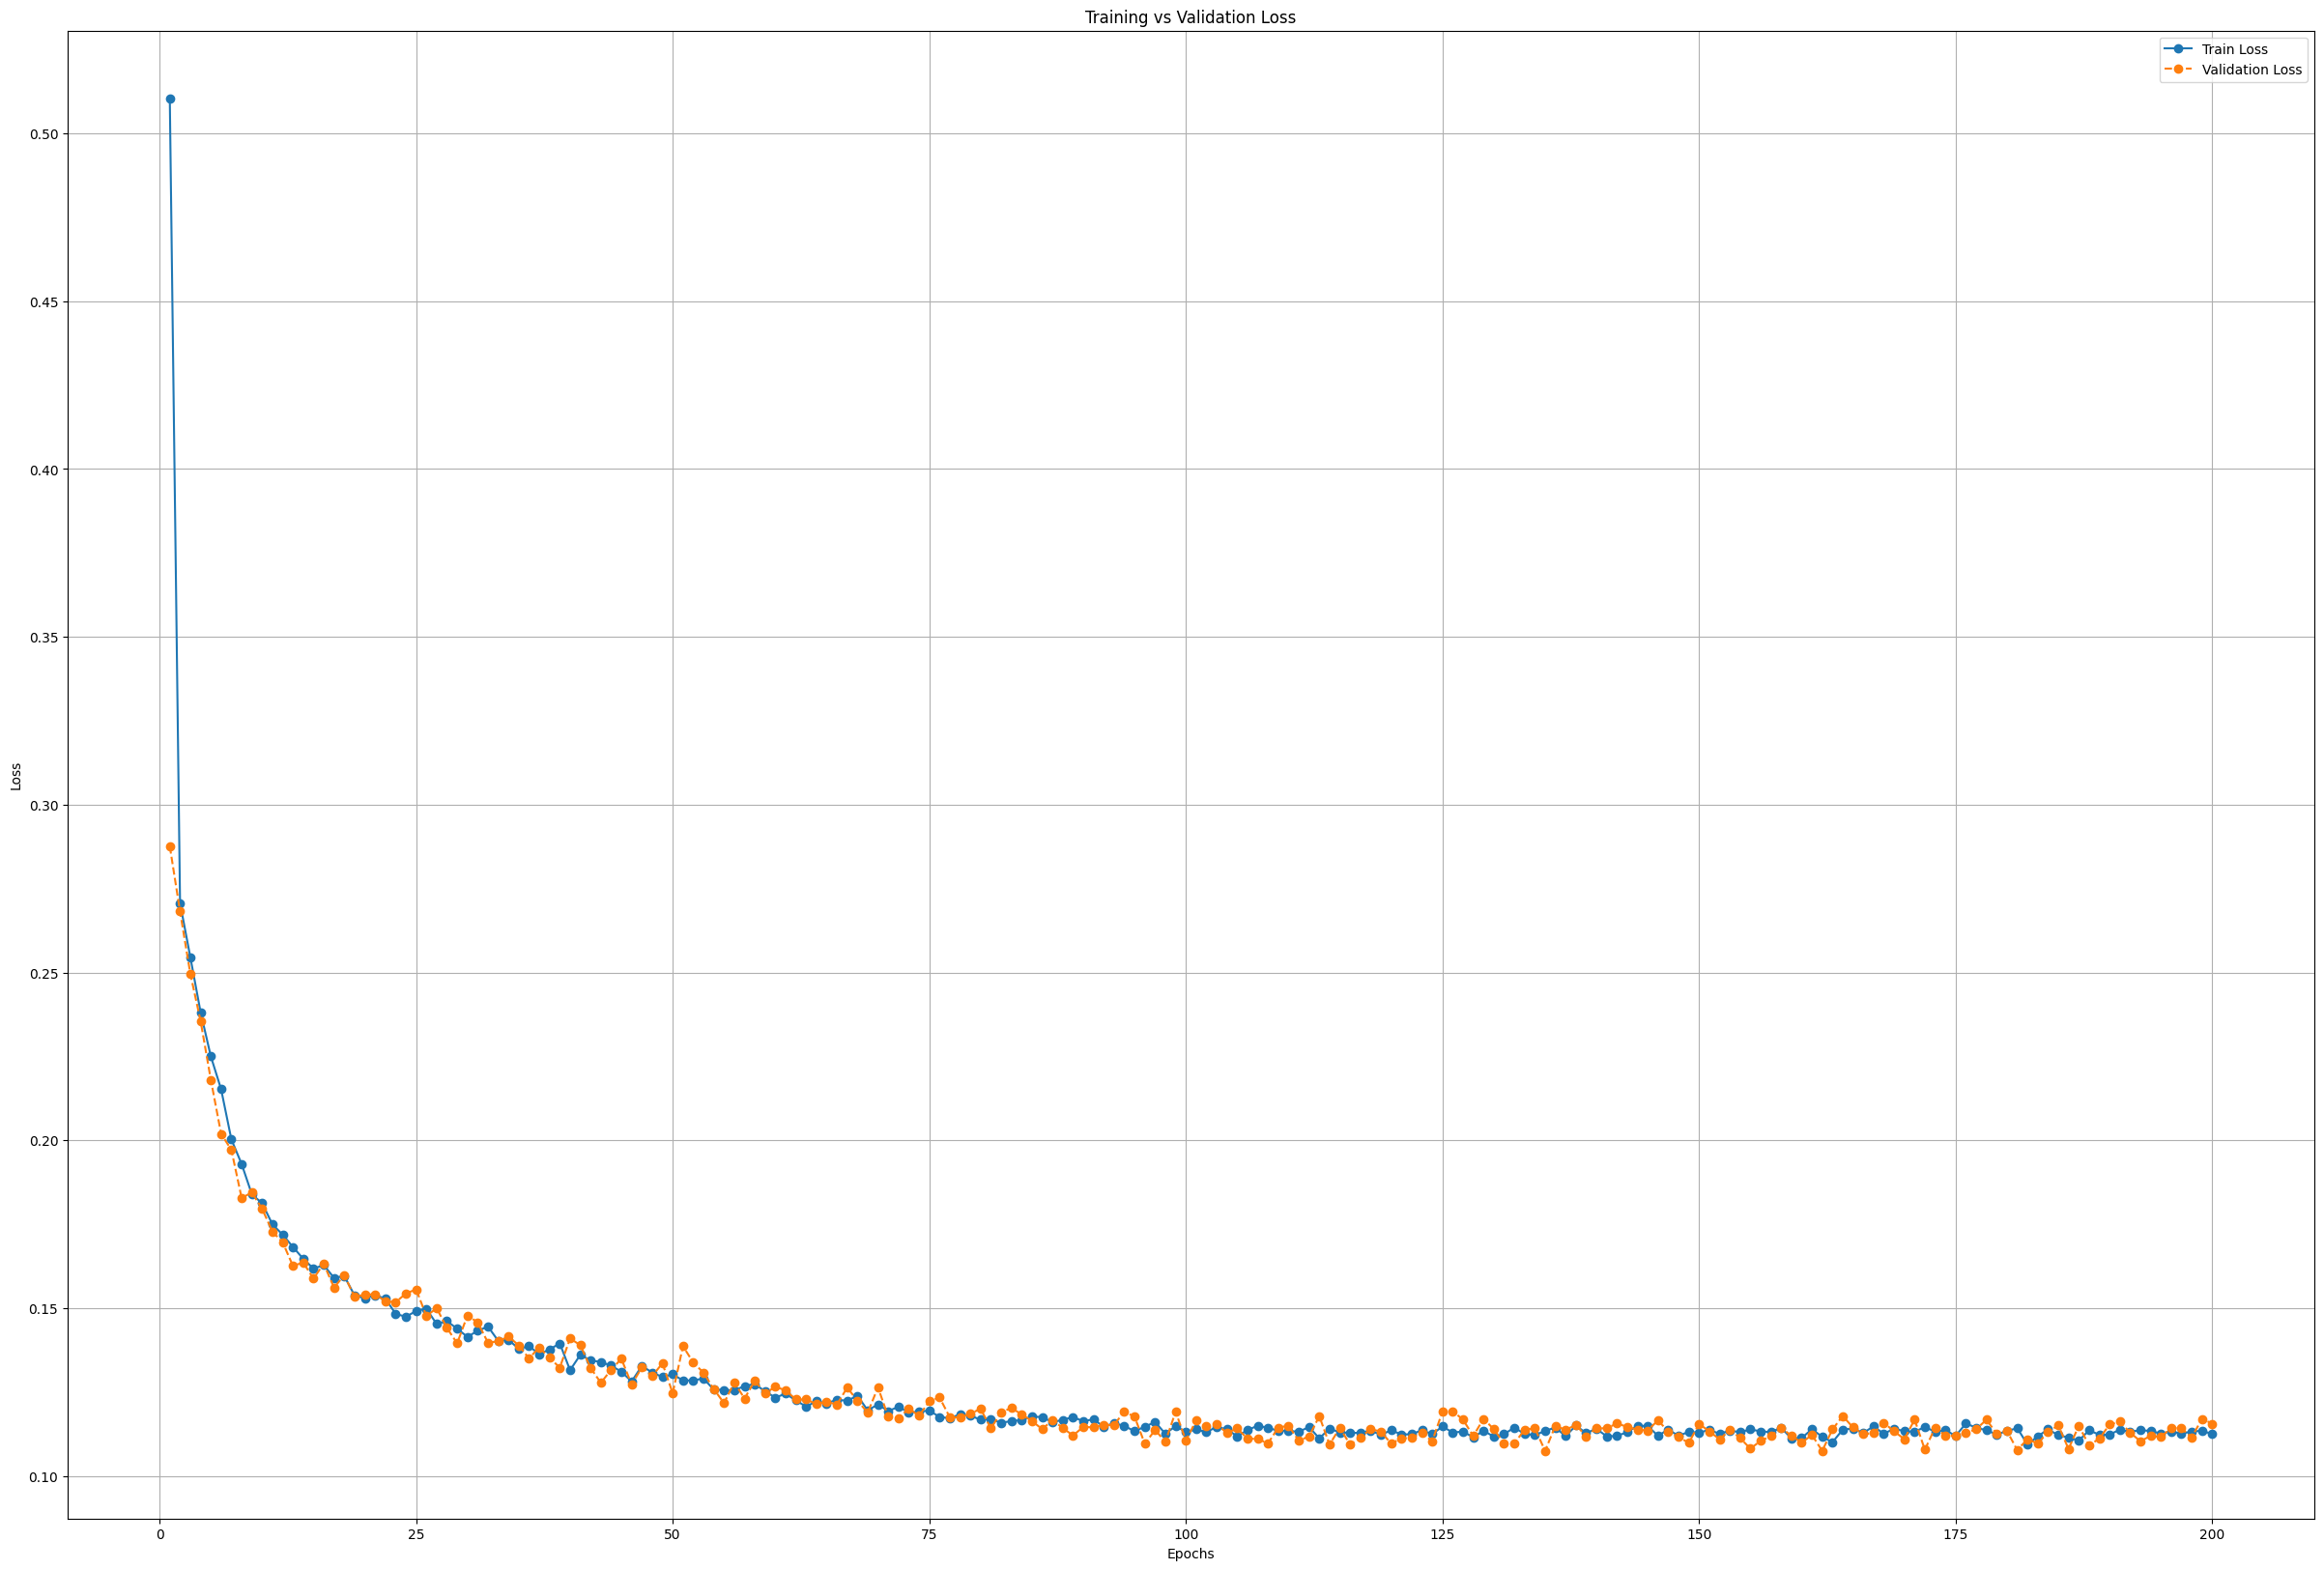

In [12]:
# Plot Loss Graph
plt.figure(figsize=(30, 20))
plt.plot(range(1, epochs + 1), train_losses, marker="o", linestyle="-", label="Train Loss")
plt.plot(range(1, epochs + 1), val_losses, marker="o", linestyle="--", label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

In [13]:
# Load the trained model
model = UNet().to(device)  # Initialize model architecture
model.load_state_dict(torch.load("best_model.pth", map_location=device))
model.eval()  # Set model to evaluation mode
print("Model loaded successfully!")

Model loaded successfully!


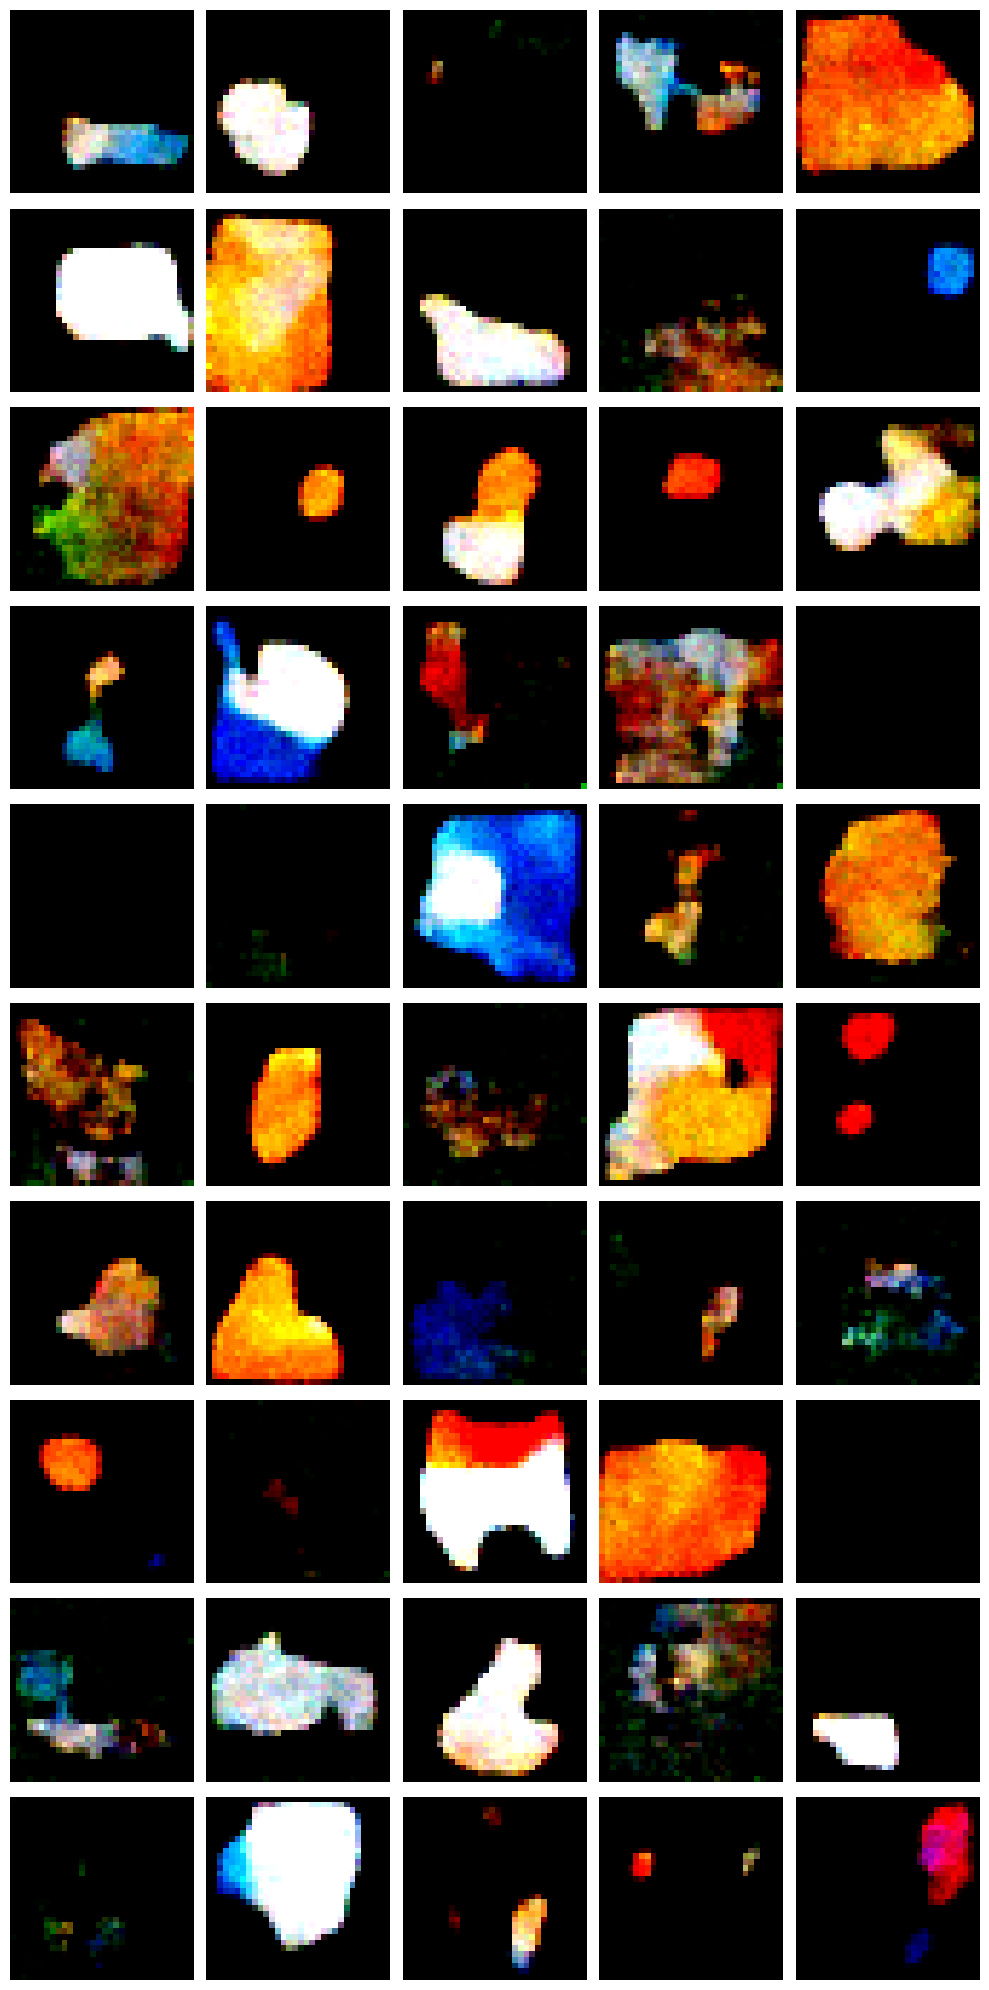

In [14]:
import matplotlib.pyplot as plt

def sample_emoji(model, diffusion, num_samples=50):
    model.eval()
    with torch.no_grad():
        sampled_images = diffusion.sample(model, (num_samples, 3, 32, 32))
    return sampled_images.cpu()

# Load trained model
model = UNet().to(device)
model.load_state_dict(torch.load("best_model.pth", map_location=device))
model.eval()

# Generate 50 images
num_samples = 50
sampled_emojis = sample_emoji(model, diffusion, num_samples)

# Define grid size (e.g., 10 rows, 5 columns)
rows, cols = 10, 5
fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))

# Plot images in grid
for i, ax in enumerate(axes.flat):
    if i < num_samples:
        img = sampled_emojis[i].permute(1, 2, 0).clamp(0, 1)  # Convert to (H, W, C)
        ax.imshow(img)
    ax.axis("off")

plt.tight_layout()
plt.show()
